# MCMC Slice sampler in Python
### returns Markov chain and log-likelihoods
### D. Craig 2019 January 15 on SciServer

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand, normal

In [4]:
import corner

In [5]:
from pyslicer import slicer

In [6]:
?slicer

### Make the fake data, a linear + noise model

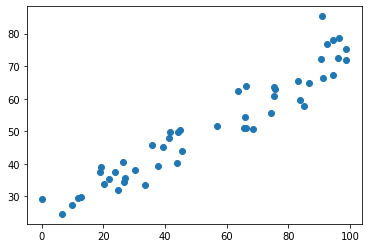

In [5]:
theta_true = [25.0,0.5] # [intercept slope]
xdata = 100*rand(50);
ydata = theta_true[0] + theta_true[1]*xdata
n = 5*normal(size=50)  # noise rms of 10
ydata += n
# ydata[j] += 40*normal(size=10) + 40  #contamination by gaussian of higher variance
plt.scatter(xdata, ydata);

In [6]:
def log_prior(theta):  #NOTE theta is a tuple
    """Jeffries prior for slopes"""
    alpha, beta, sigma = theta
    if sigma <= 0:
        return -np.inf   # log(0)
    else:
        return -0.5 * np.log(1 + beta**2) - np.log(sigma)  #Jeffreys prior for slopes

In [7]:
log_prior((24, .4, 5))

-1.683647914993237

In [8]:
def log_like(theta, xvec):
    alpha, beta, sigma = theta
    x = xvec[0]
    y = xvec[1]
    y_model = alpha + beta * x
    #return -0.5 * sum(np.log(2*np.pi*sigma**2) + (y - y_model)*(y - y_model) / sigma**2)
    return -0.5 * sum(np.log(2*np.pi*sigma**2) + (y - y_model)*(y - y_model) / sigma**2)

    #return y - y_model

In [9]:
def log_posterior(theta, xvec):
    return log_prior(theta) + log_like(theta,xvec)  #sum of logs is product in Bayes theorem numerator

## Execute; make the Markov chain:

In [24]:
%%timeit
res, likes = slicer(log_posterior, 3, [24.0, 0.5, 2.0], [xdata, ydata], N=5000);

1.86 s ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
likes

array([-221.70435657, -221.70435657, -221.79375057, ..., -156.468526  ,
       -156.27992103, -152.5547495 ])

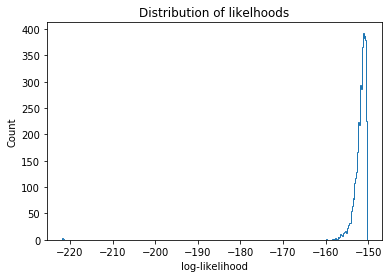

In [12]:
plt.hist(likes, bins="fd", histtype='step')
plt.title("Distribution of likelhoods");
plt.xlabel("log-likelihood")
plt.ylabel("Count");

In [13]:
A_chain = res[:,0]
B_chain = res[:,1]
N_chain = res[:,2]; # get the MCMC parameter chains out with convenient names 
                    # (marginalized samplings)

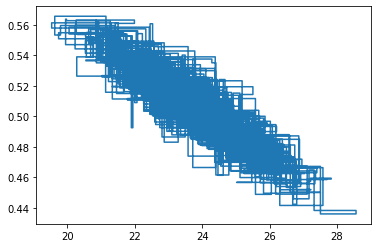

In [14]:
plt.plot(A_chain,B_chain);

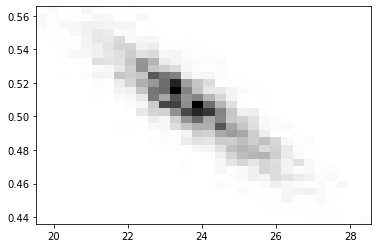

In [15]:
plt.hist2d(A_chain, B_chain, bins=30,cmap=plt.cm.Greys);

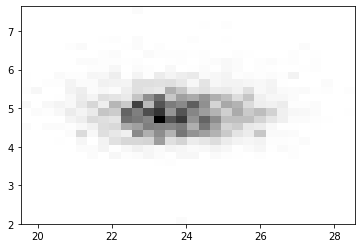

In [16]:
plt.hist2d(A_chain, N_chain, bins=30, cmap=plt.cm.Greys);

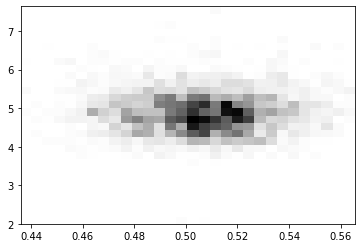

In [17]:
plt.hist2d(B_chain, N_chain, bins=30, cmap=plt.cm.Greys);

In [18]:
fit_idx = np.argmax(likes)

In [19]:
A_fit = res[fit_idx,0]
B_fit = res[fit_idx,1]
N_fit = res[fit_idx,2];

In [20]:
A_fit, B_fit, N_fit

(23.437415183738317, 0.5056118684837428, 4.690272531480664)

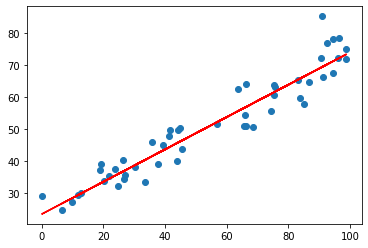

In [21]:
plt.scatter(xdata, ydata)
plt.plot(xdata, B_fit*xdata + A_fit, color='r');   # maximum likelihood model

--------------------------------------
## Background: slice sampling

Slice sampling is a Markov Chain Monte Carlo technique that tries to cut down on the amount of tuning needed to get a sample from the asymptotic distribution. Here I will try to explain it to myself.

Suppose we have a distribution (or something proportional to one): $ p(x) $. We pick a point $ x_0.$ Then we find a $ y_0 = p(x_0)$

<img src="slice-sampling-fig1.png" width=50%/>

Next, pick a point using a uniform random number generator on the interval $[0,y_0]$: this gives us $y$, 
$y = \text{Uniform}[0, y_0]$. $y$ defines a 'height' at the point $x_0$ that is below the probablility density. This also defines a _slice_ across $p(x)$ at height $y$, I'll call it $\cal{S}$. Now $\cal S$ is an interval, but of course we _don't_ know where it ends at either high or low values of $x$ yet.

<img src="slice-sampling-fig2.png" width=50%/>

Pick a width $w$, and let $L = x_0 - w$ and $R = x_0 + w.$ Next, grow the width until $L$ and $R$ lie _outside_ $\cal S$.  This can be detected by when both $p(L)$ and $p(R)$ are both _less_ than $y$: $p(L) < y \text{ and } p(R) < y.$

There are various choices for growing $w$ to find the edges of the slice: muliplicative, additive, etc.

Next, find a point in $\cal S$ by picking a point $x_1$ (randomly) in $[L,R]$ such that $ y < p(x_1)$ :

- if you fail, just try again with a new random number, until you hit it.
- if you miss, you can (carefully) shrink the interval until you get an acceptable point.

The point $x_1$ that is accepted will be a sample from the distribution.

See: Neal, "Slice Sampling," _The Annals of Statistics_ 2003, vol. 31 (705-767). This is available online.

In [22]:
res

array([[24.        ,  0.5       ,  2.        ],
       [23.95637395,  0.5       ,  2.        ],
       [23.95637395,  0.5065557 ,  2.        ],
       ...,
       [24.19541808,  0.49734484,  6.87847576],
       [24.19541808,  0.49734484,  5.84754359],
       [24.41230878,  0.49734484,  5.84754359]])

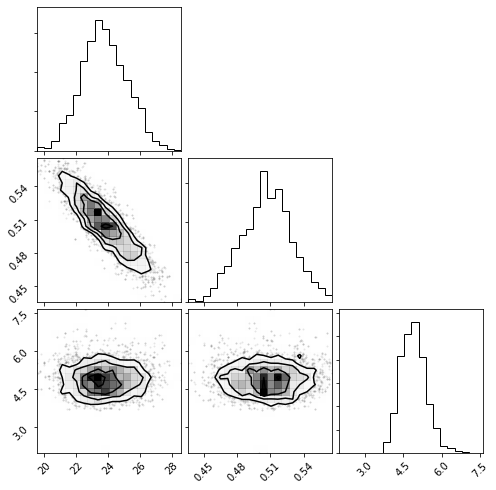

In [23]:
figc = corner.corner(res)

In [1]:
def fnana(X, dummy):
    x, y = X
    lf = -( (x*y)**2 + x**2 + y**2 - 8*x -8*y )/2
    return lf

In [28]:
nanares, lks = slicer(fnana, 2, np.array([1, 1]), None, N=20000, w=0.5, m=10)

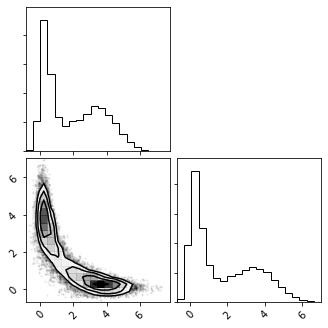

In [29]:
fign = corner.corner(nanares)